# Ejercicio de Programación: Aprendizaje PAC con Rectángulos Discretizados

En este notebook implementaremos un esquema de aprendizaje PAC sobre la clase de hipótesis correspondiente a rectángulos en el dominio $[0,1]^2$, discretizado mediante una grilla uniforme.  

Se resolverá el problema de minimización del error empírico utilizando un **algoritmo genético (GA)** con codificación binaria.

## a) Generación de datos

1. Defina una grilla uniforme $\mathcal{G}_{N}$ sobre $[0,1]$, con $N=50$, lo cual induce un total de $N^{2}$ celdas.  
2. Elija una función objetivo $f$ realizable de la clase de rectángulos.  
3. Muestree $m=300$ puntos $x_i \sim \text{Uniform}([0,1]^2)$ y genere el conjunto $S = \{ (x_i, f(x_i)) \}_{i=1}^m$.  
4. Visualice los puntos coloreando según su etiqueta binaria.

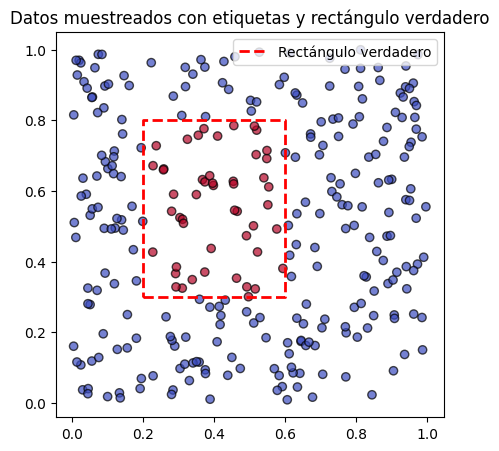

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
N = 50
m = 300
np.random.seed(42)

# Rectángulo verdadero en índices de la grilla
true_rect = (10, 30, 15, 40)  # [a,b]x[c,d]
a, b, c, d = true_rect

# Función objetivo f
def f(x):
    return (a/N <= x[0] <= b/N) and (c/N <= x[1] <= d/N)

# Datos de muestreo
X = np.random.rand(m, 2)
y = np.array([1 if f(x) else 0 for x in X])

# Visualización
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", edgecolor="k", alpha=0.7)
rect_x = [a/N, b/N, b/N, a/N, a/N]
rect_y = [c/N, c/N, d/N, d/N, c/N]
plt.plot(rect_x, rect_y, 'r--', lw=2, label="Rectángulo verdadero")

plt.title("Datos muestreados con etiquetas y rectángulo verdadero")
plt.legend()
plt.show()

## b) Implementación del Algoritmo Genético (GA)

1. Representamos un rectángulo $[a,b]\times[c,d]$ mediante 4 enteros entre 0 y $N$, codificados en binario.  
2. Definimos la función de evaluación con el error empírico:

$$
L_S(h) = \frac{1}{m}\sum_{i=1}^m \mathbf{1}[h(x_i)\neq f(x_i)]
$$  

3. Operadores genéticos implementados:
- Selección por torneo binario determinista,  
- Cruza de un punto,  
- Mutación (bit flip),  
- Reemplazo con elitismo.  
4. Visualizamos la convergencia de la función de aptitud.

In [8]:
import random

# Codificación: 4 enteros -> binario
def encode(rect, Nbits=6):
    return "".join([format(val, f"0{Nbits}b") for val in rect])

def decode(chrom, Nbits=6):
    vals = [int(chrom[i:i+Nbits], 2) for i in range(0, len(chrom), Nbits)]
    a,b,c,d = vals
    if a > b: a,b = b,a
    if c > d: c,d = d,c
    return (a,b,c,d)

# Fitness = 1 - error empírico
def empirical_error(rect, X, y, N=50):
    a,b,c,d = rect
    preds = np.array([1 if (a/N <= x[0] <= b/N and c/N <= x[1] <= d/N) else 0 for x in X])
    return np.mean(preds != y)

def fitness(chrom, X, y, N=50):
    rect = decode(chrom)
    return 1 - empirical_error(rect, X, y, N)

# Operadores del Algoritmo genetico
def tournament(pop, fits, k=2):
    contenders = random.sample(range(len(pop)), k)
    best = max(contenders, key=lambda i: fits[i])
    return pop[best]

def crossover(p1, p2):
    point = random.randint(1, len(p1)-1)
    return p1[:point] + p2[point:], p2[:point] + p1[point:]

def mutate(chrom, pmut=0.01):
    return "".join([bit if random.random()>pmut else str(1-int(bit)) for bit in chrom])

# Algoritmo genetico
def run_ga(X, y, N=50, ngen=50, popsize=30, pmut=0.01):
    Nbits = 6
    Lchrom = 4*Nbits
    pop = [encode((np.random.randint(0,N), np.random.randint(0,N),
                   np.random.randint(0,N), np.random.randint(0,N)), Nbits)
           for _ in range(popsize)]
    
    best_hist = []
    for g in range(ngen):
        fits = [fitness(chrom, X, y, N) for chrom in pop]
        elite = pop[np.argmax(fits)]
        new_pop = [elite]
        while len(new_pop) < popsize:
            p1, p2 = tournament(pop,fits), tournament(pop,fits)
            c1,c2 = crossover(p1,p2)
            new_pop.append(mutate(c1, pmut))
            if len(new_pop) < popsize:
                new_pop.append(mutate(c2, pmut))
        pop = new_pop
        best_hist.append(max(fits))
    best = decode(elite)
    return best, best_hist


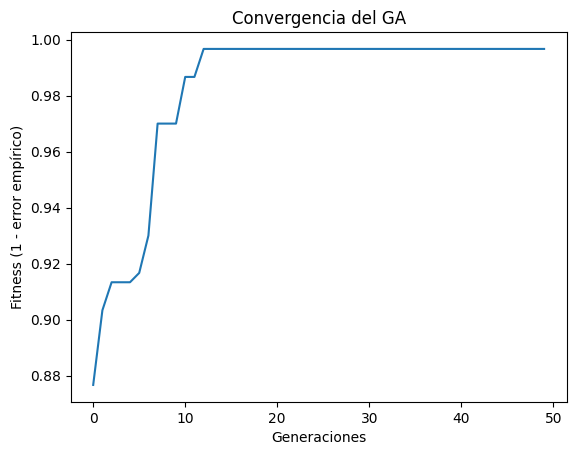

Rectángulo verdadero: (10, 30, 15, 40)
Rectángulo aprendido: (11, 29, 15, 40)


In [9]:
best_rect, hist = run_ga(X, y)

plt.plot(hist)
plt.xlabel("Generaciones")
plt.ylabel("Fitness (1 - error empírico)")
plt.title("Convergencia del GA")
plt.show()

print("Rectángulo verdadero:", true_rect)
print("Rectángulo aprendido:", best_rect)

## c) Resultados y Análisis (mediana de 21 ejecuciones independientes)

1. Dibujar el mejor rectángulo encontrado sobre la nube de puntos.  
2. Reportar el error empírico $L_S(h)$.  
3. Evaluar el error verdadero $L_D(h)$ sobre una muestra nueva de $m=1000$.  
4. Repetir el experimento para distintos valores de $m$ y graficar $L_D(h)$ vs $m$.  

Rectángulo (mediana 21 veces): (11, 30, 15, 39)
Error empírico L_S(h): 0.006666666666666667
Error verdadero L_D(h): 0.015


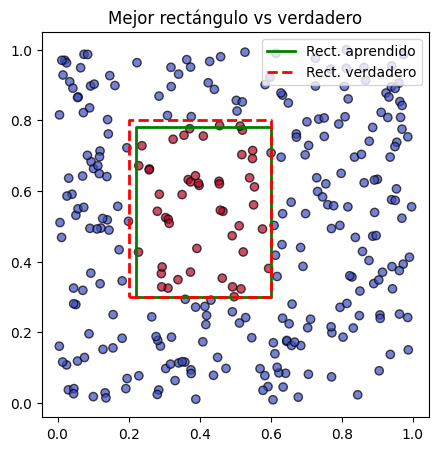

In [15]:
# Repetir 21 veces y tomar la mediana
results = []
seeds = range(21)  
for seed in seeds:
    np.random.seed(seed)
    best_rect, _ = run_ga(X, y)
    err_emp = empirical_error(best_rect, X, y)
    results.append((best_rect, err_emp))

errs = [e for (_,e) in results]
median_idx = np.argsort(errs)[len(errs)//2]
rect_med, err_med = results[median_idx]

print("Rectángulo (mediana 21 veces):", rect_med)
print("Error empírico L_S(h):", err_med)

# Error verdadero con muestra nueva
m_test = 1000
X_test = np.random.rand(m_test,2)
y_test = np.array([1 if f(x) else 0 for x in X_test])
err_true = empirical_error(rect_med, X_test, y_test)

print("Error verdadero L_D(h):", err_true)

# Visualización
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", edgecolor="k", alpha=0.7)
a,b,c,d = rect_med
plt.plot([a/N,b/N,b/N,a/N,a/N],[c/N,c/N,d/N,d/N,c/N],'g-', lw=2,label="Rect. aprendido")
a,b,c,d = true_rect
plt.plot([a/N,b/N,b/N,a/N,a/N],[c/N,c/N,d/N,d/N,c/N],'r--', lw=2,label="Rect. verdadero")
plt.legend()
plt.title("Mejor rectángulo vs verdadero")
plt.show()


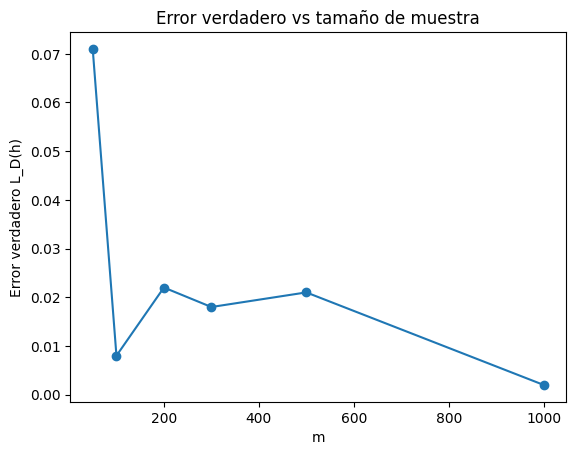

m=50, L_D(h)≈0.0710
m=100, L_D(h)≈0.0080
m=200, L_D(h)≈0.0220
m=300, L_D(h)≈0.0180
m=500, L_D(h)≈0.0210
m=1000, L_D(h)≈0.0020


In [18]:
# Error verdadero vs distintos valores de m (reproducible con semillas fijas)
m_values = [50,100,200,300,500,1000]
err_vs_m = []

for i, m_val in enumerate(m_values):
    np.random.seed(i) 
    X_train = np.random.rand(m_val,2)
    y_train = np.array([1 if f(x) else 0 for x in X_train])
    
    best_rect, _ = run_ga(X_train,y_train)
    
    # semilla distinta pero fija para test
    np.random.seed(100+i)  
    X_test = np.random.rand(1000,2)
    y_test = np.array([1 if f(x) else 0 for x in X_test])
    
    err = empirical_error(best_rect,X_test,y_test)
    err_vs_m.append(err)

plt.plot(m_values, err_vs_m, marker="o")
plt.xlabel("m")
plt.ylabel("Error verdadero L_D(h)")
plt.title("Error verdadero vs tamaño de muestra")
plt.show()

for m_val, err in zip(m_values, err_vs_m):
    print(f"m={m_val}, L_D(h)≈{err:.4f}")


5. Comparar los resultados con la teoría PAC para clases finitas:

$$
|\mathcal{H}| = \binom{N}{2}^2, \quad 
m \geq \frac{1}{\epsilon}\log\left(\frac{|\mathcal{H}|}{\delta}\right)
$$

Basicamente comparar las cotas con los resultados empíricos nos permite decir, por ejemplo, que si queremos garantizar un error 𝜖 = 0.05 con probabilidad 0.95 necesitamos alrededor de  m≈345 muestras. En los experimentos observados, cuando usamos  𝑚 por encima de esa cota (p.ej. m=500 o 𝑚 = 1000) el error verdadero medido suele ser pequeño y mas acorde con la predicción PAC. Cuando 𝑚 está por debajo (p.ej. m=300) los errores verdaderos observados pueden ser más altos.